## Notebook para la prueba de Porvenir Pensiones

##### Una de las principales ventajas de contar con datos estructurados en una serie temporal, es que nos permiten realizar analísis a través de herramientas estadísticas y econométricas como: evaluación de estacionariedad para las realizaciones de la muestra (¿la serie de tiempo -en adelante st, que describe el volumen de transacciones es determinística, estocástica, o un poco de ambos?), evaluación de correlación serial (¿la st para el volumen de transacciones tiene una tendencia predecible o cambia de dirección de manera abrupta entre cada periodo?), visualización de filtros para promedios móviles (¿podemos establecer estrategias respuesta a los movimientos de la st?), entre otras.

In [16]:
#Iniciar con importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import random
import statsmodels.api as sm
import tkinter as tk
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate, LSTM
from keras.layers import BatchNormalization, SpatialDropout1D
from keras.callbacks import Callback
from keras.models import Model
from keras.optimizers import Adam

ModuleNotFoundError: No module named 'keras'

In [19]:
#Leer la base de datos
file = "data_01.txt"
dataf=pd.read_csv(file,sep='\t')

In [20]:
#Revisar el tipo de datos que contiene el dataset
print(dataf.dtypes)
print(len(dataf))
#Revisar sí hay missing values
print ('# de valores vacios:')
print (dataf.isnull().sum())

fecha         object
idTerminal     int64
oper           int64
dtype: object
775466
# de valores vacios:
fecha         0
idTerminal    0
oper          0
dtype: int64


In [21]:
#Convertir el tipo de datos de la variable fecha
dataf['fecha']=pd.to_datetime(dataf['fecha'])
print(dataf.dtypes)

fecha         datetime64[ns]
idTerminal             int64
oper                   int64
dtype: object


In [10]:
#Revisión a la cantidad de operaciones y de terminales
cantidadOperaciones=len(dataf.oper.unique())
print('Existen '+ str(cantidadOperaciones) + ' tipos de operaciones que maneja la entidad bancaria')
cantidadTerminales=len(dataf.idTerminal.unique())
print('Existen '+ str(cantidadTerminales) + ' terminales a cargo de la entidad bancaria')

Existen 46 tipos de operaciones que maneja la entidad bancaria
Existen 47 terminales a cargo de la entidad bancaria


In [22]:
#Se elige las cinco operaciones con mayor frecuencia en los datos
tab = pd.crosstab(index=dataf["oper"],columns="frecuencia")
tab_orden=tab.sort_values('frecuencia',ascending=False)
print(tab_orden[0:5])

col_0  frecuencia
oper             
0          423929
3          127399
1           79195
7           50662
4           35817


In [23]:
#Se eligen cinco terminales al azar
auxTerm=dataf.idTerminal.unique()
terminalesAleat = random.choices(auxTerm,k=5)
print(terminalesAleat)
a=terminalesAleat[0]
b=terminalesAleat[1]
c=terminalesAleat[2]
d=terminalesAleat[3]
e=terminalesAleat[4]

[1746, 1805, 1864, 1995, 1759]


##### Se programa para tomar la primera posición del array de terminales al azar. Adicionalmente, se deja fijo el número de operación por "0", pero se puede ir cambiando conforme se necesite. Por limitaciones de computo se opta más adelante por no hacer un loop en el modelo de aprendizaje que tome las diferentes combinaciones de terminal y operación.

                     fecha  idTerminal  oper
8      2017-01-31 08:53:53        1746     0
17     2017-01-31 09:03:54        1746     0
19     2017-01-31 09:05:13        1746     0
24     2017-01-31 09:12:04        1746     0
26     2017-01-31 09:13:00        1746     0
...                    ...         ...   ...
774968 2017-05-31 20:42:04        1746     0
774974 2017-05-31 20:43:03        1746     0
775025 2017-05-31 20:53:29        1746     0
775035 2017-05-31 20:55:04        1746     0
775039 2017-05-31 20:56:31        1746     0

[12271 rows x 3 columns]
          fecha  Frecuencia
0    2017-01-31         230
1    2017-02-01         232
2    2017-02-02         134
3    2017-02-03         111
4    2017-02-04          67
..          ...         ...
113  2017-05-27          97
114  2017-05-28          36
115  2017-05-29          34
116  2017-05-30         200
117  2017-05-31         205

[118 rows x 2 columns]


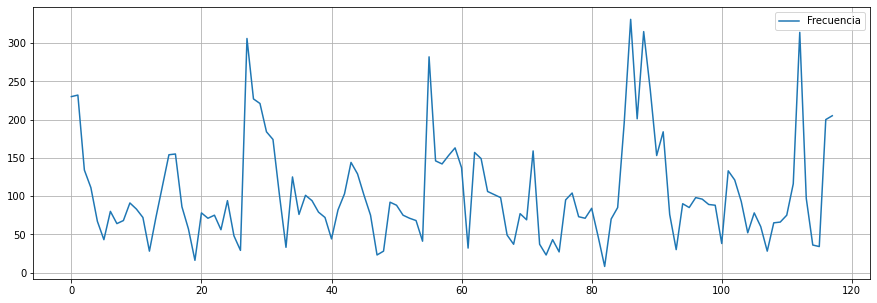

In [24]:
#Crear df 
terminal_a=dataf.query('idTerminal == @a and oper == 0',inplace=False)
print(terminal_a)
#Agrupar la frecuencia de las operaciones de manera diaria
terminal_as = terminal_a.groupby([terminal_a['fecha'].dt.date])['oper'].count().reset_index(name='Frecuencia')
print(terminal_as)
terminal_as.set_index('fecha',inplace=True)
print(terminal_as)
print(terminal_as.dtypes)
#Visualizar la st para el ensamblaje i 
terminal_as.plot(grid=True,figsize=(15,5))
plt.show()

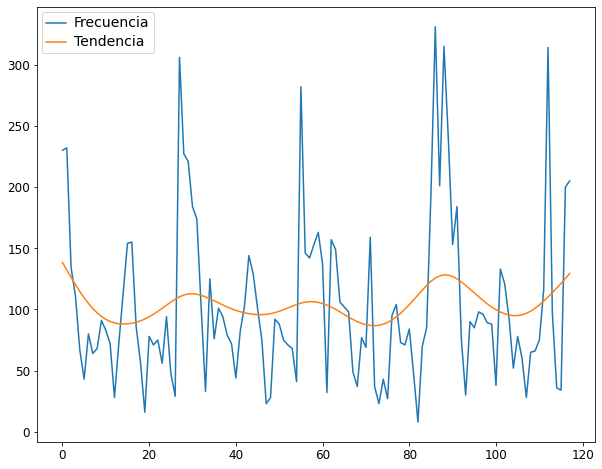

In [25]:
#Graficar contra la tendencia
terminal_as_ciclo, terminal_as_tend = sm.tsa.filters.hpfilter(terminal_as['Frecuencia'])
terminal_as['Tendencia'] = terminal_as_tend
terminal_as[['Frecuencia', 'Tendencia']].plot(figsize=(10, 8), fontsize=12)
legend = plt.legend()
legend.prop.set_size(14)
plt.show()

In [26]:
#Graficar contra promedios móviles
terminal_as_ma = terminal_as.rolling(5).mean()
terminal_as_ma1 = terminal_as.rolling(10).mean()
terminal_as_ma2 = terminal_as.rolling(15).mean()
terminal_as['prod_mov5'] = terminal_as_ma
terminal_as['prod_mov10'] = terminal_as_ma1
terminal_as['prod_mov15'] = terminal_as_ma2
plot = terminal_as[['Frecuencia', 'prod_mov5','prod_mov10','prod_mov15']].plot(figsize=(10, 8), fontsize=12)
plt.show()

ValueError: Wrong number of items passed 2, placement implies 1

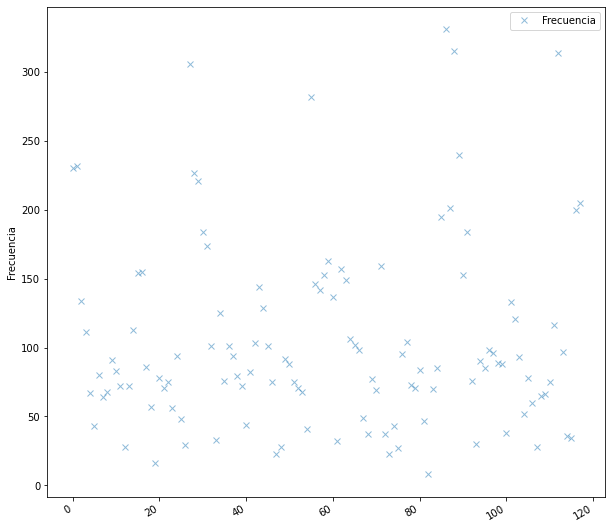

In [28]:
#Revisar la distribución de las realizaciones para st.
col_graf = ['Frecuencia'] 
ejes = terminal_as[col_graf].plot(marker='x', alpha=0.5, linestyle='None',figsize=(10,10),subplots=True)
for eje in ejes:
  eje.set_ylabel('Frecuencia')
plt.show()

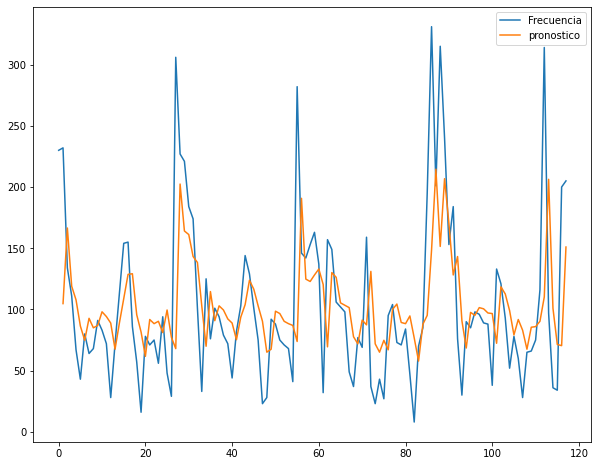

In [27]:
#Estimar con modelo ARIMA
modelo = sm.tsa.ARIMA(terminal_as['Frecuencia'].iloc[1:], order=(1, 0, 0))  
resultados = modelo.fit(disp=-1)  
terminal_as['pronostico'] = resultados.fittedvalues  
plot = terminal_as[['Frecuencia', 'pronostico']].plot(figsize=(10, 8))
plt.show()

### Observaciones importantes sobre la data y el modelo a implementar
* Se debe generar periodos de tiempo comparables entre cada categoría de operación. Por lo cual, se opta por transformar la variable "fecha" de 'horas exactas' -lo cual emula una realización continua de la st,  a un periodo regular como lo puede ser 'diaria' -para obtener observaciones discretas de la st.
* Para trabajar el modelo de aprendizaje con variables categóricas, se requiere la incorporación de *embeddings*, los cuales se incluyen como: *weekday* y *month*. Lo cual nos permite aprovechar las características de la variable 'fecha'.
* El modelo se recupera de la página: https://www.aprendemachinelearning.com/pronostico-de-ventas-redes-neuronales-python-embeddings/ y se considera adecuado para el análisis del problema, en tanto está creando una red neuronal con profundidad suficiente para aprovechar los datos brindados. 

##### Se agrega las dos variables categóricas y se convierte la st en aprendizaje supervisado con un set de entrenamiento.

In [ ]:
#Modelo de aprendizaje
terminal_as['weekday']=[x.weekday() for x in terminal_as.index]
terminal_as['month']=[x.month for x in terminal_as.index]
print(terminal_as)

PASOS=7 #periodo rezagado
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    terminal_as = pd.DataFrame(data)
    cols, names = list(), list()
    
    for i in range(n_in, 0, -1):
        cols.append(terminal_as.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    for i in range(0, n_out):
        cols.append(terminal_as.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Cargar los valores del dataframe que tenemos
values = terminal_as['Frecuencia'].values
values = values.astype('float32')
# Normalizar Función
scaler = MinMaxScaler(feature_range=(-1, 1))

values=values.reshape(-1, 1)

scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, PASOS, 1)
reframed.reset_index(inplace=True, drop=True)

contador=0
reframed['weekday']=terminal_as['weekday']
reframed['month']=terminal_as['month']

for i in range(reframed.index[0],reframed.index[-1]):
    reframed['weekday'].loc[contador]=terminal_as['weekday'][i+8]
    reframed['month'].loc[contador]=terminal_as['month'][i+8]
    contador=contador+1
print(reframed.head())

In [ ]:
reordenado=reframed[ ['weekday','month','var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)','var1(t)'] ]
reordenado.dropna(inplace=True)

training_data = reordenado.drop('var1(t)',axis=1)#.values
target_data=reordenado['var1(t)']
#training_data.head()
print(reordenado)
numerito=len(reordenado)

valid_data = training_data[numerito-30:numerito]
valid_target=target_data[numerito-30:numerito]

training_data = training_data[0:numerito-30]
target_data=target_data[0:numerito-30]
print(training_data.shape,target_data.shape,valid_data.shape,valid_target.shape)
#training_data.head()

def crear_modeloEmbeddings():
    emb_dias = 2 
    emb_meses = 2

    in_dias = Input(shape=[1], name = 'dias')
    emb_dias = Embedding(7+1, emb_dias)(in_dias)
    in_meses = Input(shape=[1], name = 'meses')
    emb_meses = Embedding(12+1, emb_meses)(in_meses)

    in_cli = Input(shape=[PASOS], name = 'cli')

    fe = concatenate([(emb_dias), (emb_meses)])

    x = Flatten()(fe)
    x = Dense(PASOS,activation='tanh')(x)
    outp = Dense(1,activation='tanh')(x)
    model = Model(inputs=[in_dias,in_meses,in_cli], outputs=outp)

    model.compile(loss='mean_absolute_error', 
                  optimizer='adam',
                  metrics=['MSE'])

    model.summary()
    return model

EPOCHS=80

model = crear_modeloEmbeddings()

continuas=training_data[['var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)']]
valid_continuas=valid_data[['var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)']]

history=model.fit([training_data['weekday'],training_data['month'],continuas], target_data, epochs=EPOCHS
                 ,validation_data=([valid_data['weekday'],valid_data['month'],valid_continuas],valid_target))


results=model.predict([valid_data['weekday'],valid_data['month'],valid_continuas])
print( len(results) )
plt.scatter(range(len(valid_target)),valid_target,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

compara = pd.DataFrame(np.array([valid_target, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
print(compara2.head(12))

compara2['real'].plot()
compara2['prediccion'].plot()
plt.show()

ultimosDias = terminal_as['2017-05-01':'2017-05-15']

# load dataset
values = ultimosDias['Frecuencia'].values

# ensure all data is float
values = values.astype('float32')
# normalize features
#scaler = MinMaxScaler(feature_range=(-1, 1))

values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension

scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, PASOS, 1)
reframed.reset_index(inplace=True, drop=True)

contador=0
reframed['weekday']=ultimosDias['weekday']
reframed['month']=ultimosDias['month']

for i in range(reframed.index[0],reframed.index[-1]):
    reframed['weekday'].loc[contador]=ultimosDias['weekday'][i+8]
    reframed['month'].loc[contador]=ultimosDias['month'][i+8]
    contador=contador+1
reframed.head()

reordenado=reframed[ ['weekday','month','var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)'] ]
reordenado.dropna(inplace=True)

values = reordenado.values
x_test = values[5:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
print(x_test)
ultDiaSemana = reordenado.weekday[len(reordenado.index)-1]

def agregarNuevoValor(x_test,nuevoValor,ultDiaSemana):
    for i in range(x_test.shape[2]-3):
        x_test[0][0][i+2] = x_test[0][0][i+3]
    ultDiaSemana=ultDiaSemana+1
    if ultDiaSemana>6:
        ultDiaSemana=0
    x_test[0][0][0]=ultDiaSemana
    x_test[0][0][1]=12
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test,ultDiaSemana

results=[]
for i in range(10):
    dia=np.array([x_test[0][0][0]])
    mes=np.array([x_test[0][0][1]])
    valores=np.array([x_test[0][0][2:9]])
    parcial=model.predict([dia, mes, valores])
    results.append(parcial[0])
    print('pred',i,x_test)
    x_test,ultDiaSemana=agregarNuevoValor(x_test,parcial[0],ultDiaSemana)

adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted
prediccion10días = pd.DataFrame(inverted)
prediccion10días.columns = ['pronostico']
prediccion10días.plot()

In [29]:
#Ventana con agradecimiento
ventana=tk.Tk()
ventana.title('Presentado por Javier Orjuela Vargas')
ventana.geometry('500x200+500+300')
ventana.configure(background='white')
el=tk.Label(ventana,text='GRACIAS',bg='green',fg='white')
el.pack(padx=5,pady=5,ipadx=5,ipady=5,fill=tk.X)
image=tk.PhotoImage(file='descarga.gif')
image=image.subsample(1,1)
label=tk.Label(image=image)
label.pack()

ventana.mainloop()

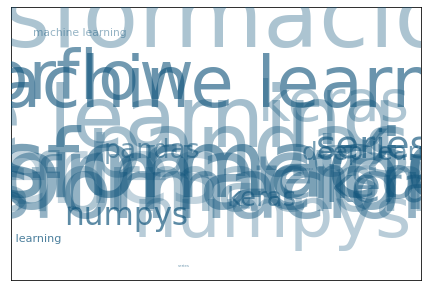

In [12]:
#Realizando imágen para informe
eqs = []
eqs.append((r"machine learning"))
eqs.append((r"deep learning"))
eqs.append((r"transformación"))
eqs.append((r"tiempo"))
eqs.append((r"series"))
eqs.append((r"pandas"))
eqs.append((r"numpys"))
eqs.append((r"keras"))
eqs.append((r"tensorflow"))
plt.axes([0.025, 0.025, 0.95, 0.95])

for i in range(24):
    index = np.random.randint(0, len(eqs))
    eq = eqs[index]
    size = np.random.uniform(1, 100)
    x,y = np.random.uniform(0, 1, 2)
    alpha = np.random.uniform(0.25, .75)
    plt.text(x, y, eq, ha='center', va='center', color="#11557c", alpha=alpha,
         transform=plt.gca().transAxes, fontsize=size, clip_on=True)
plt.xticks(())
plt.yticks(())

plt.show()

#### *Referencias*

##### Montenegro, Alvaro *Análisis de Series de Tiempo*, Editorial Pontificia Universidad Javeriana